In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time # delay within program
from math import *
import random
import pickle
import os

import nidaqmx # laser output
from pyueye import ueye
from pypyueye import Camera

from improc import *

# Inits and checks

In [7]:
templates,bodies = load_templates()
cam,task = init_instruments()

In [3]:
bgs = make_vec_bg(cam,task,[0,1],total_time=20)

In [6]:
cam.exit()

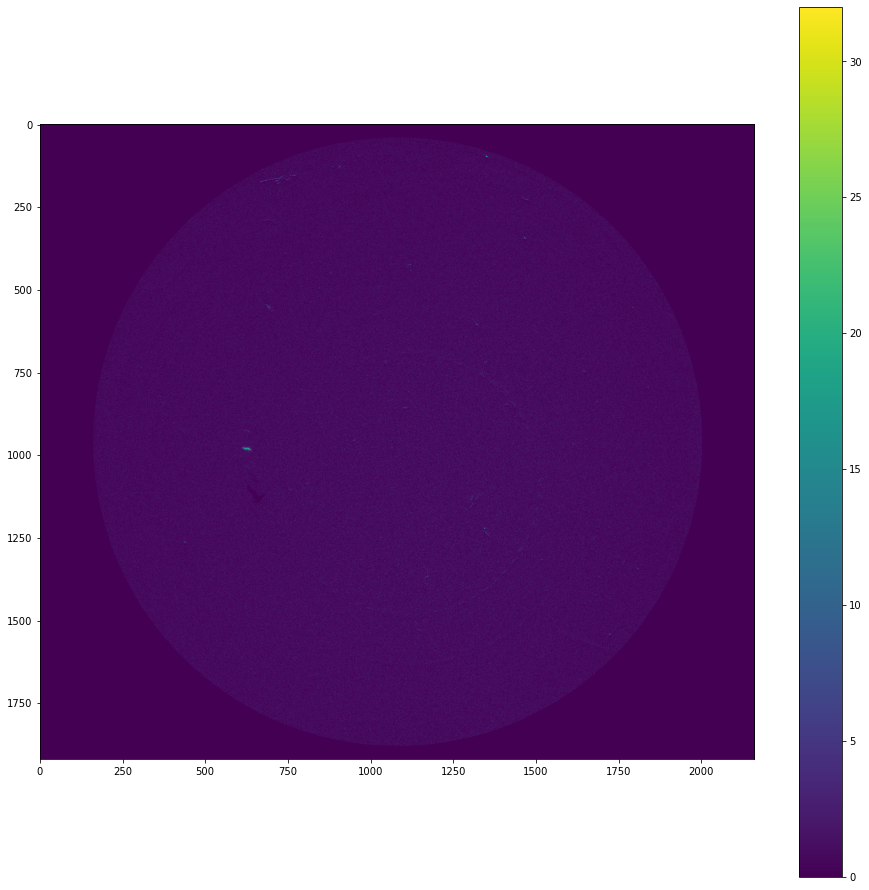

In [11]:
# Check that things are working
plt.figure(figsize=(16,16))
img = grab_im(cam,bgs[0])
plt.imshow(img)
plt.colorbar();

[{'loc': array([626.21052632, 981.10526316]), 'img': array([[1, 2, 0, ..., 1, 0, 1],
       [2, 3, 2, ..., 3, 0, 2],
       [0, 1, 1, ..., 0, 1, 0],
       ...,
       [0, 1, 0, ..., 0, 2, 2],
       [3, 1, 0, ..., 2, 0, 0],
       [3, 0, 1, ..., 0, 0, 3]], dtype=uint8), 'scores': array([193692,  65002]), 'angs': array([180,   0]), 'endpts': array([[613, 635],
       [979, 983]]), 'body': 150}]


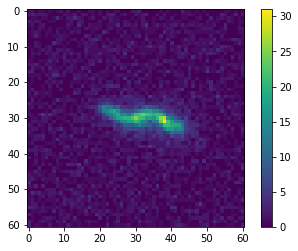

In [12]:
worms = find_worms(img,templates,bodies)
print(worms)
plt.imshow(worms[0]['img'])
plt.colorbar();

# AIY test

In [14]:
track,angs,lights = if_stmt_angle(0,cam,task,bgs,templates,bodies,total_time=60)

Finding orientation
elapsed 2

1
	 667.79 -975.33
	body 30 head 60 light 0
2
	 659.78 -976.44
	body 30 head 270 light 1
3
	 654.66 -977.09
	body 330 head 90 light 1
5
	 650.61 -977.84
	body 120 head 330 light 1
6
	 648.71 -980.54
	body 120 head 120 light 0
7
	 648.19 -979.23
	body 300 head 150 light 0
8
	 649.97 -976.49
	body 300 head 210 light 0
10
	 650.86 -973.76
	body 60 head 90 light 0
11
	 651.94 -970.7
	body 60 head 60 light 0
12
	 654.69 -966.06
	body 60 head 30 light 1
14
	 656.86 -962.75
	body 60 head 30 light 1
15
	 659.2 -959.8
	body 60 head 0 light 1
16
	 664.6 -956.65
	body 30 head 30 light 0
18
	 672.02 -954.05
	body 30 head 330 light 1
19
	 677.77 -953.59
	body 30 head 60 light 0
20
	 682.68 -953.24
	body 30 head 330 light 1
22
	 689.55 -954.24
	body 330 head 0 light 1
23
	 694.54 -955.05
	body 30 head 0 light 1
24
	 698.82 -955.0
	body 30 head 0 light 1
26
	 707.58 -953.58
	body 30 head 0 light 1
27
	 712.38 -953.65
	body 330 head 330 light 0
28
	 717.89 -956.03
	body 

In [7]:
np.save('Data/09_09_track1.npy',track)
np.save('Data/09_09_angles1.npy',angs)
np.save('Data/09_09_lights1.npy',lights)

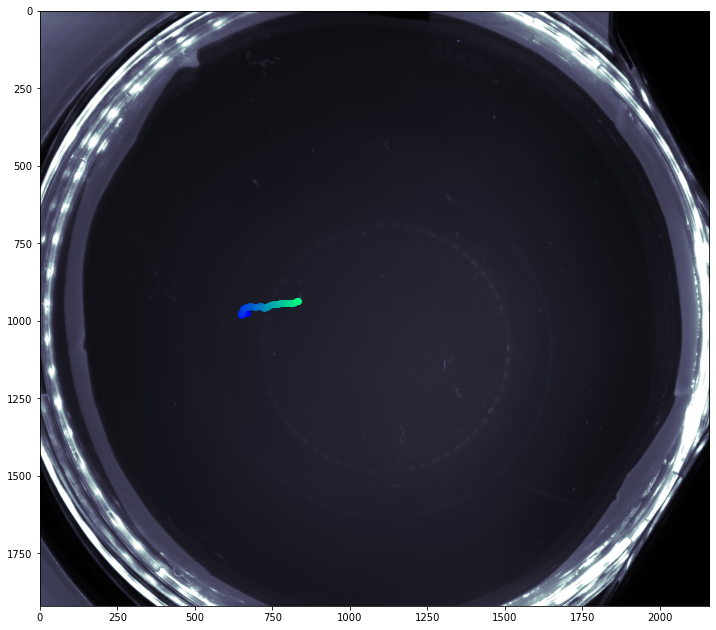

In [16]:
fig,ax = plt.subplots(1)
img = grab_im(cam,None)
ax.imshow(img,cmap='bone')
fig.set_size_inches((12,12))
NPOINTS = track.shape[0]
ax.set_prop_cycle('color',plt.cm.winter(np.linspace(0,1,NPOINTS)))
for i in range(NPOINTS-1):
    ax.scatter(track[i,1],track[i,2])
    ax.set_aspect('equal','box')

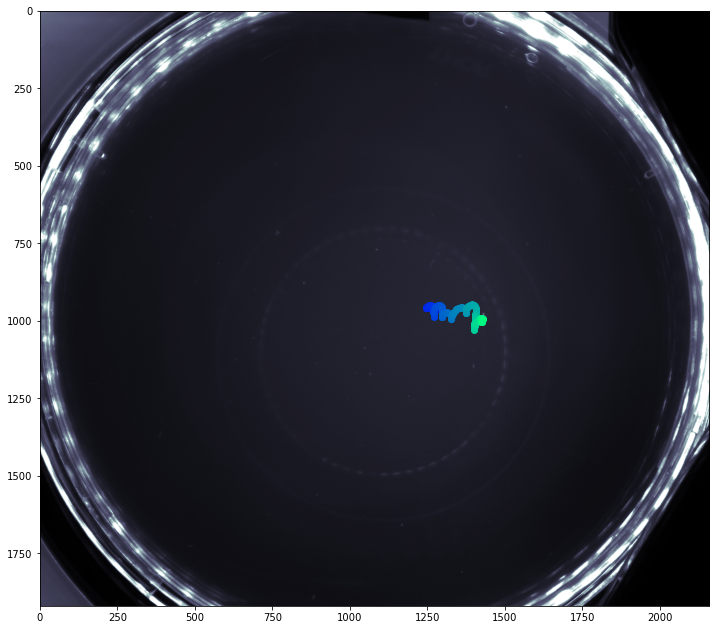

In [24]:
fig,ax = plt.subplots(1)
img = grab_im(cam,None)
ax.imshow(img,cmap='bone')
fig.set_size_inches((12,12))
NPOINTS = track.shape[0]
ax.set_prop_cycle('color',plt.cm.winter(np.linspace(0,1,NPOINTS)))
for i in range(NPOINTS-1):
    ax.scatter(track[i,1],track[i,2])
    ax.set_aspect('equal','box')

# TD

In [18]:
def tabular_Q_agent(direction,light_vec,f_ind,Q_chkpt=None,t_chkpt=0,delay=0,alpha=.05,gamma=0.5,total_time=600,track_time=10,ht_time=3):
    # Fills in a value table theta x light, where light is discretized as in light_vec.
    # delay is how much time in sec between each sample
    # alpha is the learning rate for averaging
    # total_time is in seconds
    # direction is target direction.
    
    # Q_chkpt and t_chkpt are to continue previous trials. Q_chkpt takes the last np array of Q values and 
    # t_chkpt is the approximate last time.
    
    data_dir = './Data/'
    
    NUM_DEGS = 12 # 12 for 30 degree increments
    DEG_INCR = int(360/NUM_DEGS)
    
    def get_eps(t, start=1, end=.1, tau=total_time/4):
        # Returns the epsilon value at t given a start eps, end, and time constant
        # For exponential decay:
        #return (start-end)*np.exp(-t/tau) + end  
        # For constant (good for initial tests):
        return .1
    
    
    # Initialization block
    if Q_chkpt is None:
        Q_table = np.random.randn(NUM_DEGS,NUM_DEGS,len(light_vec))  # random init for now
    else:
        Q_table = Q_chkpt
    Q_obs = [[[[] for i in range(2)] for j in range(NUM_DEGS)] for k in range(NUM_DEGS)] # keep track of updates
        # The 24's above are the number of options [-180,180) in increments of 15
    track = []
    rewards = []
    bg = bgs[0]    
    START = True
    state_inds = [0,0]
    
    # Initialize starting points to junk
    head,old_loc = [1,1],[2,2]

    # Initialize all timers
    elapsed = Timer(total_time)
    track_el = Timer(track_time)
    ht_el = Timer(ht_time)  
    
    while not elapsed.check(): 
        
        # Collect image and make sure worm exists
        img = grab_im(cam,bg)
        worms = find_worms(img,templates,bodies,ref_pts=[head],num_worms=1)
        
        if worms is None:
            task.write(0)
            bg = bgs[0]
            print("Worm not found")
            continue
        worm = worms[0]
        head = worm['endpts'][:,0]
        
        
        # Update table block
        # light_ind and state_ind should still be from previous loop
        if START:
            reward = 0
        else:
            reward = proj(worm['loc']-last_loc, [np.cos(direction*pi/180),-np.sin(direction*pi/180)]) # Get reward
            if np.isnan(reward) or np.abs(reward)>10:
                reward = 0
        old_state_inds = state_inds
        last_loc = worm['loc']
        rewards.append(reward)
        
        # finding state
        body_dir = relative_angle(worm['body'],direction)
        head_body = relative_angle(worm['angs'][0],worm['body'])
        state_inds = [int((body_dir+180)//DEG_INCR), int((head_body+180)//DEG_INCR)]
        
        if not START:
            # Q table update step:
            # Q_t+1 (s,a) <- Q_t(s,a) + alpha([r+gamma*max_a'(Q_t(s',a'))] - Q_t(s,a))
            Q_table[old_state_inds[0],old_state_inds[1],light_ind] = \
                Q_table[old_state_inds[0],old_state_inds[1],light_ind] + \
                alpha*((reward+gamma*np.max(Q_table[state_inds[0],state_inds[1],:])) - \
                       Q_table[old_state_inds[0],old_state_inds[1],light_ind])
            
            Q_obs[old_state_inds[0]][old_state_inds[1]][light_ind].append(reward)

        
        # Light selection and action block
        eps = get_eps(elapsed.t+t_chkpt)
        if np.random.random() < eps or START:
            light_ind = random.choice(range(len(light_vec)))
            light = light_vec[light_ind]
            START = False
        else:
            # Choose greedy action
            light_ind = np.argmax(Q_table[state_inds[0],state_inds[1],:])
            light = light_vec[light_ind]
        task.write(light)
        bg = bgs[light_ind]
        
        
        # Tracking block
        if track_el.check():
            track.append(np.hstack([elapsed.t,worm['loc']]))
            #print('Time',int(elapsed.t)+t_chkpt,'\tang:',int(worm['body']),'loc:',worm['loc'])
            #print('\tReward:',round(reward,3))
            with open(data_dir+'Qtab_running'+f_ind+'.json','wb') as f:
                pickle.dump(Q_table, f)
            with open(data_dir+'Qobs_running'+f_ind+'.json','wb') as f:
                pickle.dump(Q_obs, f)
            with open(data_dir+'Track_running'+f_ind+'.json','wb') as f:
                pickle.dump(track, f)
            with open(data_dir+'Rewards_running'+f_ind+'.json','wb') as f:
                pickle.dump(rewards, f)

        if ht_el.check():
            head,SWITCH = ht_quick(worm,old_loc)
            old_loc = worm['loc']
#             if SWITCH:
#                 print('\t\tSwitched')
        
        # Update maintenance variables and step delay
        elapsed.update()
        track_el.update()
        ht_el.update()
        time.sleep(delay)
    
    task.write(0)
    return np.array(track),Q_table,np.array(rewards)

In [ ]:
data_dir = './Data/'
track = []
Qs = []
rewards = []
start_hr = 0
last_Q = int(start_hr/.25)-1
Qtab = None #np.load(data_dir+'Qtab_'+'909_'+str(last_Q)+'.json',allow_pickle=True)

for hr in np.arange(64-last_Q)+last_Q+1: # Run for many hours, fingers crossed
    print('On hour:',round(hr/4,3))
    flabel = '916_'+str(hr)
    
    bgs = make_vec_bg(cam,task,[0,1],total_time=20)
    tr,Q,Rs = tabular_Q_agent((90*hr)%360,[0,1],flabel,Q_chkpt=Qtab,t_chkpt=900*hr,alpha=0.05,total_time=900)
    track.append(tr)
    Qs.append(Q)
    rewards.append(Rs)
    
    with open(data_dir+'Qtab_'+flabel+'.json','wb') as f:
        pickle.dump(Q, f)
    with open(data_dir+'Track_'+flabel+'.json','wb') as f:
        pickle.dump(tr, f)
    with open(data_dir+'Rewards_'+flabel+'.json','wb') as f:
        pickle.dump(Rs, f)
    
    Qtab = np.load(data_dir+'Qtab_'+flabel+'.json',allow_pickle=True)
    print('Mean rewards:',round(np.mean(Rs),4))
    
    plt.plot(np.linspace(hr/4,hr/4+1/4,len(Rs)),Rs)

On hour: 0.0


In [ ]:
flabel = '909'
with open(data_dir+'Qtab_fin_'+flabel+'.json','wb') as f:
    pickle.dump(Qs, f)
with open(data_dir+'Track_fin_'+flabel+'.json','wb') as f:
    pickle.dump(track, f)
with open(data_dir+'Rewards_fin_'+flabel+'.json','wb') as f:
    pickle.dump(rewards, f)

In [10]:
task.write(0)

1

In [16]:
all_rewards = []
for i in range(12):
     all_rewards.append(np.load('Data/Rewards_909_'+str(i)+'.json',allow_pickle=True))

In [17]:
all_rewards = np.hstack(all_rewards)

In [18]:
all_rewards.shape

(46658,)

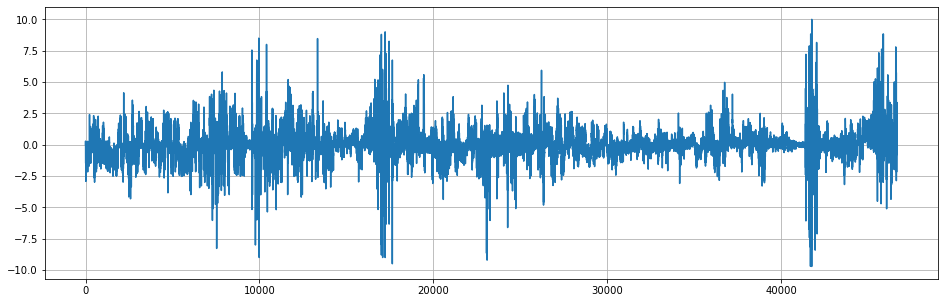

In [21]:
plt.figure(figsize=(16,5));
plt.plot(all_rewards)
plt.grid()